In [1]:
import csv

In [223]:
PATH = "insurance.csv"

In [224]:
import pandas as pd
pdData = pd.read_csv(PATH)
pdData

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Predict costs using multiple linear regression
### Data cleaning
The sex and smoker column are transformed to a binary representation. The region is represented by a one-hot encoding.

In [225]:
numericData = pdData.copy()

sexCodes = {"male": 0, "female": 1}

for sex, code in sexCodes.items():
    numericData.loc[numericData["sex"] == sex, "sex"] = code
    
smokerCodes = {"yes": 1, "no": 0}

for smoker, code in smokerCodes.items():
    numericData.loc[numericData["smoker"] == smoker, "smoker"] = code
    
numericData["NW"] = numericData["region"].apply(lambda x: 1 if x == "northwest" else 0)
numericData["NE"] = numericData["region"].apply(lambda x: 1 if x == "northeast" else 0)
numericData["SW"] = numericData["region"].apply(lambda x: 1 if x == "southwest" else 0)
numericData["SE"] = numericData["region"].apply(lambda x: 1 if x == "southeast" else 0)
del numericData["region"]

charges = numericData["charges"].to_numpy()
del numericData["charges"]
matrix = numericData.to_numpy(dtype="float")

numericData

,age,sex,bmi,children,smoker,NW,NE,SW,SE
0,19,1,27.900,0,1,0,0,1,0
1,18,0,33.770,1,0,0,0,0,1
2,28,0,33.000,3,0,0,0,0,1
3,33,0,22.705,0,0,1,0,0,0
4,32,0,28.880,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,1,0,0,0
1334,18,1,31.920,0,0,0,1,0,0
1335,18,1,36.850,0,0,0,0,0,1
1336,21,1,25.800,0,0,0,0,1,0


### Solving the system
A least-square fit is performed, with the `params` variable containing the fitted parameters. `resid` stands for the squared Euclidian 2-norm (which is equal to the $R^2$ parameter if I'm not mistaken), followed by the `rank`, of the matrix and `singval` containing the singular values. We only need the `params` variable here.

In [226]:
import numpy as np
params, resid, rank, singval = np.linalg.lstsq(matrix, charges, rcond=None)

## Predicting the charges
We use the found `params` to predict the insurance costs.

In [227]:
def costFunc(params, x):
    return np.sum(params*x)

pdData["predCharges"] = numericData.apply(lambda row: costFunc(params, row.to_numpy()), axis=1)
pdData

,age,sex,bmi,children,smoker,region,charges,predCharges
0,19,female,27.900,0,yes,southwest,16884.92400,25293.713028
1,18,male,33.770,1,no,southeast,1725.55230,3448.602834
2,28,male,33.000,3,no,southeast,4449.46200,6706.988491
3,33,male,22.705,0,no,northwest,21984.47061,3754.830163
4,32,male,28.880,0,no,northwest,3866.85520,5592.493386
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,12351.323686
1334,18,female,31.920,0,no,northeast,2205.98080,3511.930809
1335,18,female,36.850,0,no,southeast,1629.83350,4149.132486
1336,21,female,25.800,0,no,southwest,2007.94500,1246.584939


### Assessing the goodness of fit
The data clearly shows some correlation, but the linear model might have been to simple, or important parameters are missing.

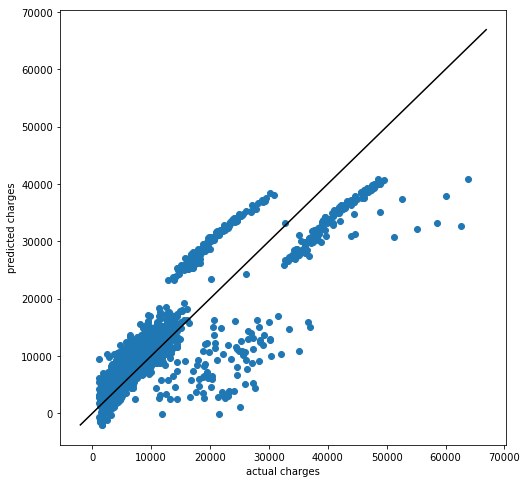

In [228]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pdData["charges"], pdData["predCharges"])
xpoints = ax.get_xlim()
ax.plot(xpoints, xpoints, color="k")
ax.set_xlabel("actual charges")
ax.set_ylabel("predicted charges")
plt.show()

## Visualization by category

### Age

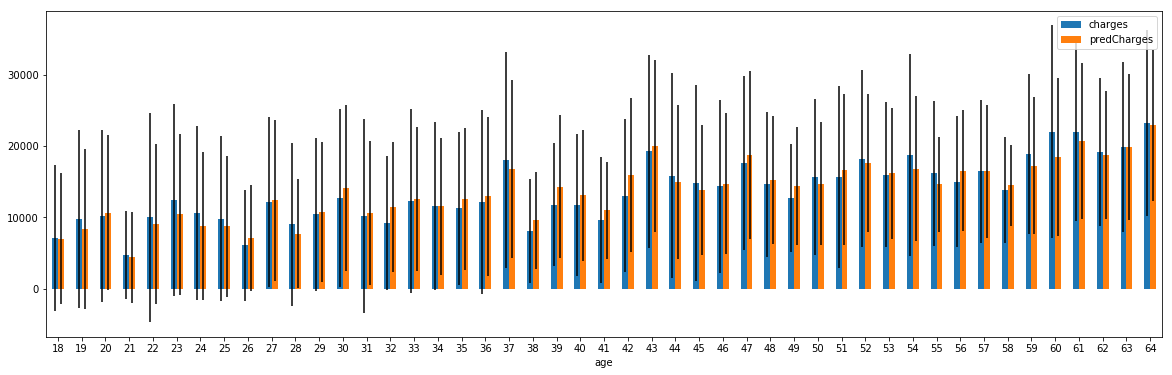

In [237]:
plt.rcParams["figure.figsize"] = [20, 6]

df = pdData[["age", "charges", "predCharges"]].copy()
groups = df.groupby("age").mean()
err = df.groupby("age").std()

ax = groups.plot.bar(rot=0, yerr=err)

### Smoker
This is by far the most influential variable.

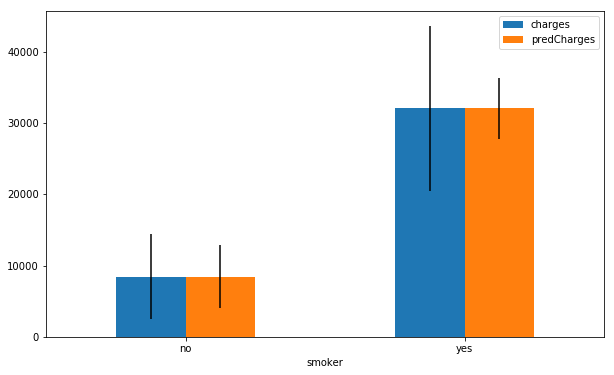

In [230]:
plt.rcParams["figure.figsize"] = [10, 6]

df = pdData[["smoker", "charges", "predCharges"]].copy()
groups = df.groupby("smoker").mean()
err = df.groupby("smoker").std()

ax = groups.plot.bar(rot=0, yerr=err)

### Region

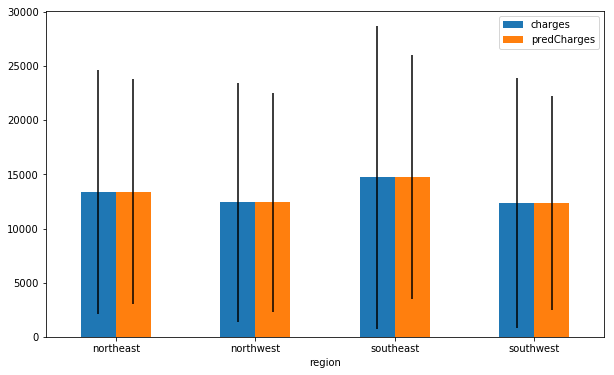

In [231]:
df = pdData[["region", "charges", "predCharges"]].copy()
groups = df.groupby("region").mean()
err = df.groupby("region").std()

ax = groups.plot.bar(rot=0, yerr=err)

### Number of children

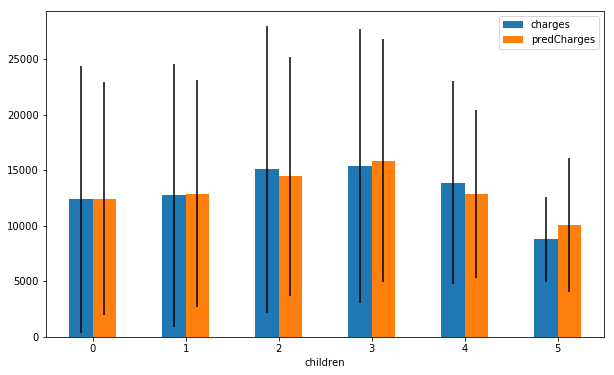

In [146]:
df = pdData[["children", "charges", "predCharges"]].copy()
groups = df.groupby("children").mean()
err = df.groupby("children").std()

ax = groups.plot.bar(rot=0, yerr=err)

### BMI
Here we first have to discretize the data in order to make a barplot.

#### Histogram
It explains the absence of error bars for bmi > 50.

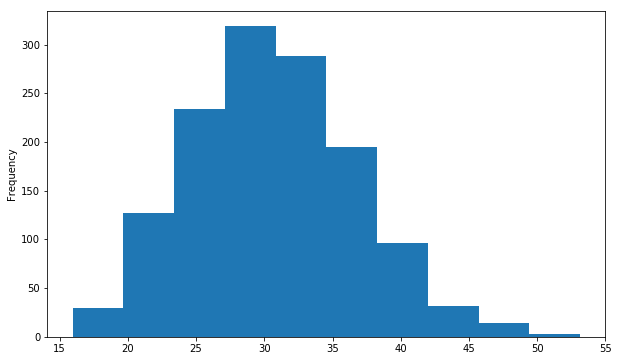

In [170]:
pdData["bmi"].plot(kind="hist")
plt.show()

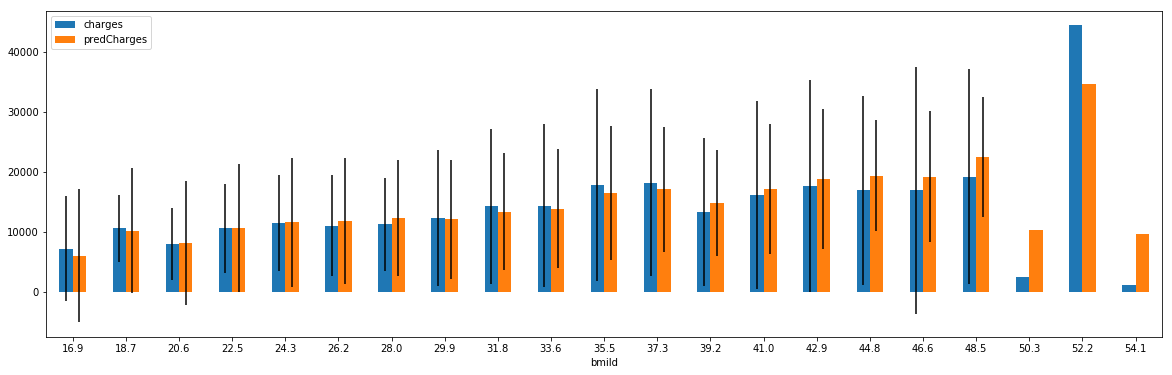

In [222]:
plt.rcParams["figure.figsize"] = [20, 6]

df = pdData[["charges", "predCharges"]].copy()

NBINS = 20
maxBmi = pdData["bmi"].max()
minBmi = pdData["bmi"].min()
bmiRange = maxBmi - minBmi
bw = bmiRange / NBINS
means = [np.around(minBmi + (x+0.5)*bw, 1) for x in range(0,NBINS+1)]

df["bmiId"] = pdData["bmi"].apply(lambda x: means[np.floor((x - minBmi) / bw).astype('int')])

groups = df.groupby("bmiId").mean()
err = df.groupby("bmiId").std()

ax = groups.plot.bar(rot=0, yerr=err)